<a href="https://colab.research.google.com/github/SiriosMEN/Competitions/blob/main/MKB_credit_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Постановка задачи

**Задача от МКБ хакатон.**

Модель оценки вероятности предъявления по гарантии для клиентов МСБ
Для заключения контрактов в рамках системы госзакупок поставщикам товаров / услуг необходимо получить гарантию исполнения контракта со стороны банков. В случае, если поставщик не выполнит контракт, заказчик предъявит денежное требование выдавшему гарантию банку. Для того, чтобы минимизировать потери от кредитного риска, необходима модель, прогнозирующая вероятность предъявления по гарантии.

Задача заключается в построении аппликационной модели оценки вероятности предъявления по отдельной гарантии. В качестве предикторов для моделирования используются данные о клиенте, включая различные собранные «анкетные» данные, а также финансовые показатели компаний. Поставщиками могут быть как юридические лица, так и индивидуальные предприниматели. Соответственно, некоторые данные могут быть присущи только ИП или только ЮЛ. Для построения модели используется основная выборка (17 891 наблюдения), в которой указана целевая переменная – факт предъявления по гарантии. В качестве результата по всем наблюдениям необходимо получить балльную оценку и значение вероятности предъявления по гарантии.

Для выявления победителя будет произведена качественная оценка построенной модели на тестовой выборке (7 330 наблюдений), которую необходимо проскорить в соответствии с построенной моделью. Помимо качества дифференцирующей способности, будет учтена интерпретируемость модели.

Решения оцениваются по метрике ROC/AUC Score. 


**Применимость** 
Возможность применения вашего решения в бизнес-процессах банка

**Интерпретируемость**
Возможность выяснить факторы модели, которые повлияли на прогноз

**Инновации**
Использование инновационных подходов при решении

Используйте те же самые id в вашем ответе, что и в тестовом датасете. Загружаемый файл должен состоять из двух колонок: "id_contract" и "TARGET" (разделитель - ";", кодировка - "utf-8".

## Подготовка

### Установка библиотек

In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

### Загрузка данных

Загрузка обучающей выборки

In [ ]:
# encoding='cp1251', separator=';'
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MKB_credit_risk/train_dataset_hackathon_mkb.csv',encoding='cp1251', sep=';')

In [ ]:
data

,id_contract,id_client,SIGN_DATE,IP_flag,TARGET,F1100,F1110,F1150,F1160,F1170,F1180,F1190,F1200,F1210,F1220,F1230,F1240,F1250,F1260,F1300,F1310,F1320,F1350,F1360,F1370,F1400,F1410,F1420,F1450,F1500,F1510,F1520,F1530,F1550,F1600,F1700,F2100,F2110,F2120,F2200,...,MANAGERCOUNTINREGION,MANAGERINNCOUNT,OKVED_CODE,PLAINTIFF_CASESNUMBER_YEAR,PLAINTIFF_SUM_YEAR,DEFENDANT_CASESNUMBER_YEAR,DEFENDANT_SUM_YEAR,THIRDOROTHERPERSON_YEAR,PLAINTIFF_CASESNUMBER_EVER,PLAINTIFF_SUM_EVER,DEFENDANT_CASESNUMBER_EVER,DEFENDANT_SUM_EVER,THIRDOROTHERPERSON_EVER,ADMITTEDNUMBER_233_YEAR,NOTADMITTEDNUMBER_233_YEAR,WINNERNUMBER_233_YEAR,SIGNEDNUMBER_233_YEAR,SUM_233_YEAR,ADMITTEDNUMBER_233_EVER,NOTADMITTEDNUMBER_233_EVER,WINNERNUMBER_233_EVER,SIGNEDNUMBER_233_EVER,SUM_233_EVER,ADMITTEDNUMBER_95_YEAR,NOTADMITTEDNUMBER_95_YEAR,WINNERNUMBER_95_YEAR,SIGNEDNUMBER_95_YEAR,SUM_95_YEAR,ADMITTEDNUMBER_95_EVER,NOTADMITTEDNUMBER_EVER,WINNERNUMBER_95_EVER,SIGNEDNUMBER_95_EVER,SUM_95_EVER,FLAG_DISQUALIFICATION,COUNT_CHANGE_YEAR,COUNT_CHANGE_EVER,BIRTHDATE,AGE,SEX_NAME,CITIZENSHIP_NAME
0,1,1847,01JAN2018:00:00:00,0,0,1.298961e+09,2154000.0,1.125573e+09,NaN,150010000.0,NaN,21224000.0,1.048287e+10,105901000.0,127510000.0,9.477348e+09,440671000.0,3.312980e+08,138000.0,1.960896e+09,1.000700e+07,-46634000.0,599497000.0,500000.0,1.028878e+09,340135000.0,NaN,340135000.0,NaN,9.480796e+09,2.499973e+09,6.907960e+09,NaN,NaN,1.178183e+10,1.178183e+10,2.370882e+09,5.294104e+10,5.057016e+10,631752000.0,...,0.0,0.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,4650,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4770,01JAN2018:00:00:00,0,0,7.337400e+07,NaN,7.337400e+07,NaN,NaN,NaN,NaN,2.161000e+07,2378000.0,NaN,1.764200e+07,1000000.0,5.530000e+05,37000.0,9.073600e+07,1.000000e+05,NaN,6780000.0,NaN,8.385600e+07,NaN,NaN,NaN,NaN,4.248000e+06,NaN,4.171000e+06,77000.0,NaN,9.498400e+07,9.498400e+07,9.315000e+06,5.218400e+07,4.286900e+07,2569000.0,...,1.0,1.0,36.00.2,6.0,2762852.0,1.0,794.0,3.0,21.0,5408695.0,39.0,882647.0,4.0,1.0,0.0,1.0,1.0,1174998.0,2.0,0.0,2.0,2.0,2738217.0,38.0,0.0,38.0,39.0,4209963.0,169.0,0.0,169.0,168.0,18351739.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,4,12237,01JAN2018:00:00:00,0,0,1.937488e+09,122828000.0,6.103280e+08,NaN,809426000.0,356828000.0,38078000.0,5.786965e+09,12001000.0,71000.0,1.232486e+09,78603000.0,4.459193e+09,4611000.0,2.685905e+09,1.516514e+09,NaN,NaN,65834000.0,1.103557e+09,627253000.0,NaN,689000.0,626564000.0,4.411295e+09,3.930000e+05,3.092581e+09,NaN,NaN,7.724453e+09,7.724453e+09,1.694054e+10,4.028466e+10,2.334412e+10,931118000.0,...,1.0,1.0,35.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,9988,01JAN2018:00:00:00,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17886,17887,3439,07APR2019:00:00:00,0,0,5.404500e+07,NaN,5.404500e+07,NaN,NaN,NaN,NaN,2.810200e+07,158000.0,NaN,2.550500e+07,NaN,2.439000e+06,NaN,7.192800e+07,1.281000e+06,NaN,61939000.0,1449000.0,7.259000e+06,NaN,NaN,NaN,NaN,1.

Загрузка описания полей

In [ ]:
data_description = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/MKB_credit_risk/data_description.xlsx')

In [ ]:
data_description

,Название поля,Описание
0,id_contract,Идентификатор контракта
1,id_client,Идентификатор клиента
2,SIGN_DATE,Дата подписания контракта
3,IP_flag,Флаг ИП
4,TARGET,Целевая переменная - факт наличия предъявления...
...,...,...
119,COUNT_CHANGE_EVER,Количество изменений в наименовании и организа...
120,BIRTHDATE,Дата рождения
121,AGE,Возраст
122,SEX_NAME,Пол


Загрузка тестовой выборки

In [ ]:
# encoding='cp1251', separator=';'
data_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MKB_credit_risk/test_dataset_hackathon_mkb.csv',encoding='cp1251', sep=';')

## Анализ данных

#### Проанализируем идентификаторы

In [ ]:
print(f'Форма выборки{data.shape}')
print('Уникальных идентификаторов контрактов',len(data.iloc[:,0].unique()))
print('Уникальных идентификаторов клиентов',len(data.iloc[:,1].unique()))
print(f"Всего непустых значений идентификатора клиента {data.iloc[:,1].count()}")

Форма выборки(17891, 124)
Уникальных идентификаторов контрактов 17891
Уникальных идентификаторов клиентов 8922
Всего непустых значений идентификатора клиента 17891


Вывод:


1.   Идентификаторы контрактов можно дропнуть
2.   Идентификаторы клиентов????



#### Проанализируем идентификаторы клиентов

Проверим, есть ли совпадения в клиентах между обучающей и тестовой выборками

In [ ]:
common_clients = data.query('id_client in @data_test.id_client')

In [ ]:
print('Уникальных общих идентификаторов клиентов',len(common_clients.iloc[:,1].unique()))

Уникальных общих идентификаторов клиентов 948


In [ ]:
len(common_clients['id_client'].unique())

948

#####Проверим есть ли клиенты c количествоm целевого показателя больше 1

In [ ]:
data.groupby(by='id_client',)['TARGET'].sum().sort_values(ascending=False)

id_client
5159    291
4613    278
5357    220
2483    182
8677    145
       ... 
7830      0
7831      0
7832      0
7833      0
6365      0
Name: TARGET, Length: 8922, dtype: int64

И у общих клиентов между обучающей и тестовой выборками

In [ ]:
common_clients.groupby(by='id_client',)['TARGET'].sum().sort_values(ascending=False)

id_client
5159     291
5357     220
2512     132
12467    125
11273    119
        ... 
8103       0
8102       0
8078       0
8075       0
8          0
Name: TARGET, Length: 948, dtype: int64

#### Проанализируем целевой признак

In [ ]:
print(f"Распределение между классами целевого признака \n{data['TARGET'].value_counts()}")
print(f"Количество целевых показателей {data['TARGET'].count()}")

Распределение между классами целевого признака 
0    10502
1     7389
Name: TARGET, dtype: int64
Количество целевых показателей 17891


#### Проанализируем колонки с пропусками

In [ ]:
def columns_analys(data):
  col_list = []
  full_cols = []
  col_lens = []
  for c in data.columns:
    col_lens.append([c,(data[c].count())])
    if data[c].count() < len(data):
      #print('Неполноценная колонка',c,data[c].count())
      col_list.append(c)
    
    else:
      full_cols.append(c)
  lens = pd.DataFrame(col_lens).sort_values(by=1,ascending=False)    
  print('Всего неполных колонок',len(col_list))
  print(f'Всего {data.shape[1]} колонок')
  print(f'Полные колонки{full_cols}')
  print('Длины колонок \n',lens)
  lens[1].hist(bins=50)

Всего неполных колонок 119
Всего 124 колонок
Полные колонки['id_contract', 'id_client', 'SIGN_DATE', 'IP_flag', 'TARGET']
Длины колонок 
                          0      1
0              id_contract  17891
2                SIGN_DATE  17891
3                  IP_flag  17891
4                   TARGET  17891
1                id_client  17891
..                     ...    ...
8                    F1160    346
43                   F2310    301
118      COUNT_CHANGE_YEAR    239
21                   F1320     97
117  FLAG_DISQUALIFICATION      5

[124 rows x 2 columns]


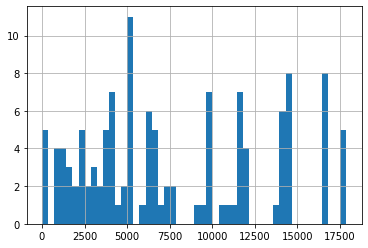

In [ ]:
columns_analys(data)

#####Вывод по анализу заполненности колонок

Полностью заполнены только первые 5 колонок: id клиента, id контракта, дата подписания контракта, флаг ИП, целевой признак. Из этих признаков для обучения потребуется только флаг ИП и целевой признак.

Всего неполных колонок 119
Всего 123 колонок
Полные колонки['id_contract', 'id_client', 'SIGN_DATE', 'IP_flag']
Длины колонок 
                          0     1
0              id_contract  7330
1                id_client  7330
2                SIGN_DATE  7330
3                  IP_flag  7330
85              OKVED_CODE  7047
..                     ...   ...
7                    F1160    79
117      COUNT_CHANGE_YEAR    79
42                   F2310    51
20                   F1320     8
116  FLAG_DISQUALIFICATION     5

[123 rows x 2 columns]


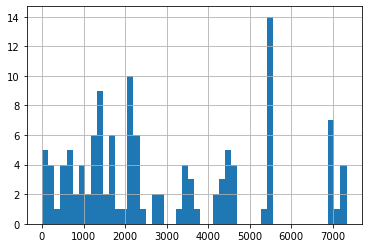

In [ ]:
columns_analys(data_test)

####Рассмотрим описание полей

In [ ]:
for i in range(len(data_description)):
  print(data_description.loc[i,'Название поля'],'---',data_description.loc[i,'Описание'])

id_contract --- Идентификатор контракта
id_client --- Идентификатор клиента
SIGN_DATE --- Дата подписания контракта
IP_flag --- Флаг ИП
TARGET --- Целевая переменная - факт наличия предъявления по гарантии
F1100 --- Внеоборотные активы
F1110 --- Нематериальные активы
F1150 --- Основные средства
F1160 --- Доходные вложения в материальные ценности
F1170 --- Долгосрочные финансовые вложения
F1180 --- Отложенные налоговые активы
F1190 --- Прочие внеоборотные активы
F1200 --- Оборотные активы
F1210 --- Запасы
F1220 --- НДС по приобретенным ценностям
F1230 --- Дебиторская задолженность
F1240 --- Краткосрочные финансовые вложения
F1250 --- Дебиторская задолженность
F1260 --- Прочие оборотные активы
F1300 --- Капитал и резервы
F1310 --- Уставный капитал
F1320 --- Собственные акции, выкупленные у акционеров
F1350 --- Добавочный капитал
F1360 --- Резервный капитал
F1370 --- Нераспределенная прибыль (непокрытый убыток)
F1400 --- Долгосрочные обязательства
F1410 --- Заёмные средства (долгосрочные)

####Проанализируем каждый признак на корреляцию, смысл и заполненность

In [ ]:
def column_etl(column_name):
  description = data_description.loc[data_description['Название поля'] == column_name,'Описание'].reset_index().loc[0,'Описание']
  print(f'Название поля: {column_name}, описание поля:', description)
  display(data[column_name].head(3))
  col_type = data[column_name].dtypes
  print(f'Тип данных {col_type}')
  if col_type != 'object':
    print('Корелляция с целевым признаком',data[column_name].corr(data['TARGET']))
    display(data[column_name].describe())
  else:
     print('Уникальные значения')
     display(data[column_name].value_counts())
  print(f'Количество заполненных значений {data[column_name].count()}')
  print('Решаем что делать с колонкой?')

In [ ]:
def all_columns(data):
  for c in data.columns:
    column_etl(c)
    print('______________')
    print('')

In [ ]:
#all_columns(data)

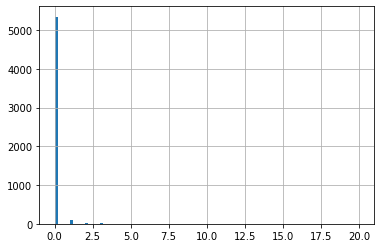

In [ ]:
data_test['COUNTCOOWNERFCSM'].hist(bins=100)

####Составим список признаков, которые можно вырезать

In [ ]:
to_drop = list(data_description['Название поля'].loc[data_description['Описание'].isin(['ОКВЭД','Идентификатор контракта','Идентификатор клиента','Дата рождения','Дата подписания контракта','Пол','Гражданство',
                                                                                        'Внеоборотные активы','Нематериальные активы','НДС по приобретенным ценностям','Краткосрочные финансовые вложения',
                                                                                        'Прочие оборотные активы','Прочие внеоборотные активы','Уставный капитал','Собственные акции, выкупленные у акционеров',
                                                                                        'Добавочный капитал','Резервный капитал','Долгосрочные обязательства','Отложенные налоговые обязательства',
                                                                                        'Доходы будущих периодов','Прочие краткосрочные обязательства','Прибыль (убыток) от продажи','Управленческие расходы',
                                                                                        'Доходы от участия в других организациях','Проценты к получению','Проценты к уплате','Текущий налог на прибыль',
                                                                                        'Прибыль (убыток) от продажи (предыдущий период)','Управленческие расходы (предыдущий период)',
                                                                                        'Прибыль (убыток) до налогообложения (предыдущий период)','Проценты к получению (предыдущий период)',
                                                                                        'Проценты к уплате (предыдущий период)','Чистая прибыль (убыток) (предыдущий период)',
                                                                                        'Дата регистрации','Код федерального округа по ОКАТО','Код федерального округа по ОКОТМО',
                                                                                        'Регистрация в ФНС. Дата регистрации','Регистрация в налоговом органе. Дата регистрации',
                                                                                        'Структура компании. Количество филиалов (Росстат)','Количество филиалов (ЕГРЮЛ)',
                                                                                        'Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди действующих компаний, зарегистрированных в том же регионе)',
                                                                                        'Количество компаний с аналогичным ИНН руководителя (поиск по ИНН руководителя среди всех действующих компаний)',
                                                                                        'Участие в арбитражных делах в качестве истца. Количество дел (за последний год)',
                                                                                        'Участие в арбитражных делах в качестве ответчика. Количество дел (за последний год)',
                                                                                        'Участие в арбитражных делах в качестве истца. Сумма, руб. (за все время)',
                                                                                        'Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 223)',
                                                                                        'Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 223)',
                                                                                        'Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 94)',
                                                                                        'Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 94)',
                                                                                        'Данные о тендерах за последний год. Число выигрышей тендеров (ФЗ 94)',
                                                                                        'Данные о госконтрактах за последний год. Число подписанных контрактов (ФЗ 94)',
                                                                                        'Данные о тендерах за все время. Число допусков к тендеру (ФЗ 94)',
                                                                                        'Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 94)',
                                                                                        'Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 94)',
                                                                                        'Наличие руководителя компании, дисквалифицированного когда-либо'
                                                                                        ])])
to_drop

['id_contract',
 'id_client',
 'SIGN_DATE',
 'F1100',
 'F1110',
 'F1190',
 'F1220',
 'F1240',
 'F1260',
 'F1310',
 'F1320',
 'F1350',
 'F1360',
 'F1400',
 'F1420',
 'F1530',
 'F1550',
 'F2200',
 'F2220',
 'F2310',
 'F2320',
 'F2330',
 'F2410',
 'F2200_LAG1',
 'F2220_LAG1',
 'F2300_LAG1',
 'F2320_LAG1',
 'F2330_LAG1',
 'F2400_LAG1',
 'DATEFIRSTREG',
 'OKATO_FED',
 'OKTMO_FED',
 'TAXREG_REGDATE',
 'TAXREGPAY_REGDATE',
 'COUNTBRANCHROSSTAT',
 'MANAGERCOUNTINREGION',
 'MANAGERINNCOUNT',
 'OKVED_CODE',
 'PLAINTIFF_CASESNUMBER_YEAR',
 'DEFENDANT_CASESNUMBER_YEAR',
 'PLAINTIFF_SUM_EVER',
 'WINNERNUMBER_233_YEAR',
 'SIGNEDNUMBER_233_YEAR',
 'ADMITTEDNUMBER_95_YEAR',
 'NOTADMITTEDNUMBER_95_YEAR',
 'WINNERNUMBER_95_YEAR',
 'SIGNEDNUMBER_95_YEAR',
 'ADMITTEDNUMBER_95_EVER',
 'NOTADMITTEDNUMBER_EVER',
 'SUM_95_EVER',
 'FLAG_DISQUALIFICATION',
 'BIRTHDATE',
 'SEX_NAME',
 'CITIZENSHIP_NAME']

####Составим список категориальных признаков

In [ ]:
categorical = list(data_description['Название поля'].loc[data_description['Описание'].isin(['Флаг ИП','Признак включения в ЕГРПО (Росстат)',
                                                                                            'Группа ОКФС','Группа ОКОПФ','Группа ОКОГУ','ОКАТО. Код региона','ОКТМО. Код','Диапазон численности персонала',

                                                                                            ])])
categorical

['IP_flag',
 'EGRPOINCLUDED',
 'OKFS_GROUP',
 'OKOPF_GROUP',
 'OKOGU_GROUP',
 'OKATO_REGIONCODE',
 'OKTMO_CODE',
 'WORKERSRANGE']

#####Составим список признаков для OE

In [ ]:
to_OE_cols= list(data_description['Название поля'].loc[data_description['Описание'].isin(['Группа ОКФС','Группа ОКОПФ','Группа ОКОГУ','Диапазон численности персонала'])])
to_OE_cols

['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE']

####Составим список признаков для заполнения NaN нулем

In [ ]:
nan_to_zero = list(data_description['Название поля'].loc[data_description['Описание'].isin(['Основные средства','Доходные вложения в материальные ценности','Долгосрочные финансовые вложения',
                                                                                            'Отложенные налоговые активы',
                                                                                            'Оборотные активы','Запасы','Дебиторская задолженность','Капитал и резервы','Нераспределенная прибыль (непокрытый убыток)',
                                                                                            'Заёмные средства (долгосрочные)','Прочие долгосрочные обязательства','Краткосрочные обязательства',
                                                                                            'Заёмные средства (краткосрочные)','Кредиторская задолженность','Активы  всего','Пассивы всего',
                                                                                            'Валовая прибыль (убыток)','Выручка','Себестоимость продаж','Коммерческие расходы','Прибыль (убыток) до налогообложения',
                                                                                            'Прочие доходы','Прочие расходы','Чистая прибыль (убыток)','Основные средства (предыдущий период)','Дебиторская задолженность (предыдущий период)',
                                                                                            'Заёмные средства (долгосрочные) (предыдущий период)','Заёмные средства (краткосрочные) (предыдущий период)',
                                                                                            'Кредиторская задолженность (предыдущий период)','Выручка (предыдущий период)','Себестоимость продаж (предыдущий период)',
                                                                                            'Коммерческие расходы (предыдущий период)','Признак включения в ЕГРПО (Росстат)','ОКАТО. Код региона',
                                                                                            'ОКТМО. Код','Структура компании. Количество совладельцев (Данные компании/ФСФР)',
                                                                                            'Структура компании. Количество совладельцев (ЕГРЮЛ)','Структура компании. Количество филиалов (Данные компании)','Структура компании. Количество филиалов (ЕГРЮЛ)',
                                                                                            'Количество компаний с аналогичными телефоном','Количество компаний с аналогичным ФИО руководителя (поиск по ФИО руководителя среди всех действующих компаний)',
                                                                                            'Участие в арбитражных делах в качестве истца. Сумма, руб. (за последний год)',
                                                                                            'Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за последний год)',
                                                                                            'Участие в арбитражных делах в качестве третьего лица. (за последний год)',
                                                                                            'Участие в арбитражных делах в качестве истца. Количество дел (за все время)',
                                                                                            'Участие в арбитражных делах в качестве ответчика. Количество дел (за все время)',
                                                                                            'Участие в арбитражных делах в качестве ответчика. Сумма, руб. (за все время)',
                                                                                            'Участие в арбитражных делах в качестве третьего лица. (за все время)',
                                                                                            'Данные о тендерах за последний год. Число допусков к тендеру (ФЗ 223)',
                                                                                            'Данные о тендерах за последний год. Число не допусков к тендеру (ФЗ 223)',
                                                                                            'Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 223)',
                                                                                            'Данные о тендерах за все время. Число допусков к тендеру (ФЗ 223)',
                                                                                            'Данные о тендерах за все время. Число не допусков к тендеру (ФЗ 223)',
                                                                                            'Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 223)',
                                                                                            'Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 223)',
                                                                                            'Данные о госконтрактах за все время. Контрактов подписано на сумму, руб. (ФЗ 223)',
                                                                                            'Данные о госконтрактах за последний год. Контрактов подписано на сумму, руб. (ФЗ 94)',
                                                                                            'Данные о тендерах за все время. Число выигрышей тендеров (ФЗ 94)',
                                                                                            'Данные о госконтрактах за все время. Число подписанных контрактов (ФЗ 94)',
                                                                                            'Количество изменений в наименовании и организационно-правовой форме за последний год',
                                                                                            'Количество изменений в наименовании и организационно-правовой форме за все время',
                                                                                            'Возраст',
                                                                                            ])])
nan_to_zero

['F1150',
 'F1160',
 'F1170',
 'F1180',
 'F1200',
 'F1210',
 'F1230',
 'F1250',
 'F1300',
 'F1370',
 'F1410',
 'F1450',
 'F1500',
 'F1510',
 'F1520',
 'F1600',
 'F1700',
 'F2100',
 'F2110',
 'F2120',
 'F2210',
 'F2300',
 'F2340',
 'F2350',
 'F2400',
 'F1150_LAG1',
 'F1230_LAG1',
 'F1410_LAG1',
 'F1510_LAG1',
 'F1520_LAG1',
 'F2110_LAG1',
 'F2120_LAG1',
 'F2210_LAG1',
 'EGRPOINCLUDED',
 'OKATO_REGIONCODE',
 'OKTMO_CODE',
 'COUNTCOOWNERFCSM',
 'COUNTCOOWNEREGRUL',
 'COUNTBRANCH',
 'COUNTBRANCHEGRUL',
 'TELEPHONECOUNT',
 'MANAGERCOUNTINCOUNTRY',
 'PLAINTIFF_SUM_YEAR',
 'DEFENDANT_SUM_YEAR',
 'THIRDOROTHERPERSON_YEAR',
 'PLAINTIFF_CASESNUMBER_EVER',
 'DEFENDANT_CASESNUMBER_EVER',
 'DEFENDANT_SUM_EVER',
 'THIRDOROTHERPERSON_EVER',
 'ADMITTEDNUMBER_233_YEAR',
 'NOTADMITTEDNUMBER_233_YEAR',
 'SUM_233_YEAR',
 'ADMITTEDNUMBER_233_EVER',
 'NOTADMITTEDNUMBER_233_EVER',
 'WINNERNUMBER_233_EVER',
 'SIGNEDNUMBER_233_EVER',
 'SUM_233_EVER',
 'SUM_95_YEAR',
 'WINNERNUMBER_95_EVER',
 'SIGNEDNUMBER_95_E

####Составим список признаков для заполнения NaN единицами

In [ ]:
nan_to_one = list(data_description['Название поля'].loc[data_description['Описание'].isin(['Структура компании. Количество совладельцев (Ростат)'])])

####Составим список признаков, которые можно дополнить словом "Неизвестно"

In [ ]:
to_fill_with_noname = list(data_description['Название поля'].loc[data_description['Описание'].isin(['Группа ОКФС','Группа ОКОПФ','Группа ОКОГУ','Диапазон численности персонала'])])
to_fill_with_noname

['OKFS_GROUP', 'OKOPF_GROUP', 'OKOGU_GROUP', 'WORKERSRANGE']

## Подготовка данных

####Подготовить два набора с вероятностью дефолта и без нее

#####Сгенерируем признак с вероятностью дефолта

In [ ]:
defolt_proba = data.groupby(by='id_client')['TARGET'].agg(['count','sum']).sort_values(by='sum',ascending=False)
defolt_proba['proba'] = defolt_proba['sum'] / defolt_proba['count']
display(defolt_proba.loc[(defolt_proba['proba'] < 1) & (defolt_proba['proba'] >0)])
print('Размер таблицы',defolt_proba.shape)

,count,sum,proba
id_client,,,
5156,66,62,0.939394
2582,55,51,0.927273
2405,33,32,0.969697
11764,17,16,0.941176
2053,16,15,0.937500
...,...,...,...
1406,6,1,0.166667
12296,2,1,0.500000
11879,2,1,0.500000


Размер таблицы (8922, 3)


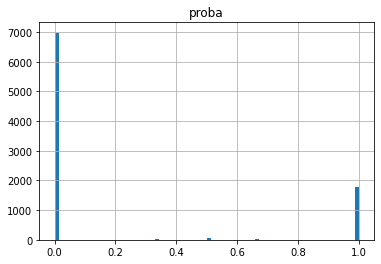

In [ ]:
defolt_proba.hist(column='proba',bins=70);

In [ ]:
def proba_generator(id):
  #print(id)
  try:
     return (defolt_proba.loc[id,'proba'])
  except:
     return( -1)

In [ ]:
data['defolt_proba'] = data['id_client'].apply(proba_generator)

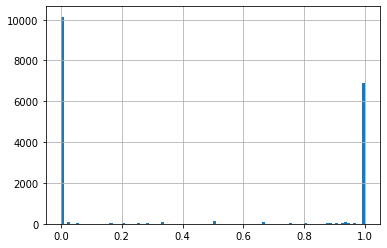

In [ ]:
data['defolt_proba'].hist(bins=100);

#####Сгенерируем признак вероятности для имеющихся данных в тестовой выборке

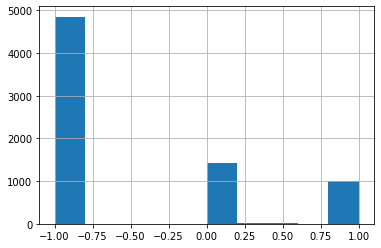

In [ ]:
data_test['defolt_proba'] = data_test['id_client'].apply(proba_generator)
data_test['defolt_proba'].hist();

In [ ]:
target= data['TARGET']

####Вырезать лишние признаки

#####Вырезать целевой признак из обучающей выборки

In [ ]:
data = data.drop(['TARGET'],axis='columns')

####Обработка пропусков

#####Функция обработки пропусков

In [ ]:
def data_preparation(data):
#####Вырезать признаки не имеющие смысла в обучающей выборке и малое количество значений и целевой признак
  data = data.drop(to_drop,axis='columns')
#####Заполнить NaN нулем для заранее определенных категорий
  data[nan_to_zero] = data[nan_to_zero].fillna(value=0)
#####Заполнить NaN словом "Неизвестно" для заранее известных категорий
  data[to_fill_with_noname] = data[to_fill_with_noname].fillna(value='Неизвестно')
#####Заполнить Nan единицами для заранее определенных категорий
  data[nan_to_one] = data[nan_to_one].fillna(value=1)
  return data

#####Обработаем пропуски обучающей и тестовой выборки

In [ ]:
train_features = data_preparation(data)

In [ ]:
test_features = data_preparation(data_test)

In [ ]:
train_features['OKOPF_GROUP']

0        Коммерческая корпоративная организация
1                                    Неизвестно
2            Коммерческая унитарная организация
3        Коммерческая корпоративная организация
4                                    Неизвестно
                          ...                  
17886        Коммерческая унитарная организация
17887      Некоммерческая унитарная организация
17888    Коммерческая корпоративная организация
17889    Коммерческая корпоративная организация
17890    Коммерческая корпоративная организация
Name: OKOPF_GROUP, Length: 17891, dtype: object

In [ ]:
train_features['OKFS_GROUP']

0                Частная собственность
1                           Неизвестно
2        Государственная собственность
3                Частная собственность
4                           Неизвестно
                     ...              
17886    Государственная собственность
17887    Государственная собственность
17888            Частная собственность
17889            Частная собственность
17890            Частная собственность
Name: OKFS_GROUP, Length: 17891, dtype: object

####Кодирование категориальных признаков

In [ ]:
def OE_coding(train_features,test_features):
  for c in to_OE_cols:
    print(c)
    encoder = OrdinalEncoder()
    encoder.fit(train_features[c].values.reshape(-1,1))
    train_features[c] = pd.DataFrame(encoder.transform(train_features[c].values.reshape(-1,1)))
    #print(train_features[c])
    test_features[c] = pd.DataFrame(encoder.transform(test_features[c].values.reshape(-1,1)))
  return train_features,test_features

In [ ]:
train_features,test_features = OE_coding(train_features,test_features)

OKFS_GROUP
OKOPF_GROUP
OKOGU_GROUP
WORKERSRANGE


In [ ]:
train_features[to_OE_cols]

,OKFS_GROUP,OKOPF_GROUP,OKOGU_GROUP,WORKERSRANGE
0,5.0,1.0,2.0,1.0
1,2.0,3.0,4.0,12.0
2,0.0,2.0,2.0,10.0
3,5.0,1.0,2.0,9.0
4,2.0,3.0,4.0,12.0
...,...,...,...,...
17886,0.0,2.0,2.0,10.0
17887,0.0,5.0,1.0,1.0
17888,5.0,1.0,2.0,0.0
17889,5.0,1.0,2.0,0.0


In [ ]:
scaler = StandardScaler(with_mean=False,)  
scaler.fit(train_features)  
train_features = scaler.transform(train_features)  
test_features = scaler.transform(test_features)

####Регуляризация

#Обучение моделей

In [ ]:
def result_saving(model,model_type):
  data_test['TARGET']= model.predict_proba(test_features)[:,1]
  now = datetime.datetime.now()
  name_of_file = str('/content/drive/MyDrive/Colab Notebooks/MKB_credit_risk/res_'+model_type+'_'+ now.strftime("%d_%m_%Y_%H_%M")+'.csv')
  data_test[['id_contract', 'TARGET']].to_csv(name_of_file, sep=';', index=False)

In [ ]:
model_RFR = RandomForestClassifier()
model_RFR.fit(train_features,target)

In [ ]:
model_CBC = CatBoostClassifier(loss_function='CrossEntropy')
model_CBC.fit(train_features,target)

In [ ]:
model_DTC = DecisionTreeClassifier()
model_DTC.fit(train_features,target)

DecisionTreeClassifier()

In [ ]:
model_GB = GradientBoostingClassifier()
model_GB.fit(train_features,target)

GradientBoostingClassifier()

In [ ]:
model_LGBM = LGBMClassifier()
model_LGBM.fit(train_features,target)

LGBMClassifier()

In [ ]:
model_MLP = MLPClassifier()
model_MLP.fit(train_features,target)

MLPClassifier()

In [ ]:
result_saving(model_MLP,'MLP')

In [ ]:
result_saving(model_LGBM,'LGBM')

In [ ]:
result_saving(model_RFR,'RFR')
result_saving(model_CBC,'CBC')

In [ ]:
result_saving(model_DTC,'DTC')

In [ ]:
result_saving(model_GB,'GB')

###Проверим важность признаков

###Возможные улучшения

* Необходимо внимательно отсмотреть какие отрицательные значения должны быть заменены на положительные
* Дату регистрации и дату регистрации в ФНС пока удалил,но возможно надо превратиить ее в года.
* Отбросить лишние признаки после анализа важности признаков в RF
* Попробовать обучить CatBoost без масштабирования и JrdinalEncoding